In [1]:
import mne 
import numpy as np
import os

In [13]:
# List of BDF file paths in order
raw_files = [
    r'C:\Users\LSA\Downloads\raw-20251119T095513Z-1-001\raw\Pilot02\EEG\Biosemi\2025-10-07-pilot02-block01.bdf',
    # r'C:\Users\LSA\Downloads\raw-20251119T095513Z-1-001\raw\Pilot04\EEG\2025-10-20-pilot04-block01.bdf',
    # r'C:\Users\LSA\Downloads\raw-20251119T095513Z-1-001\raw\Pilot04\EEG\2025-10-20-pilot04-block01.bdf',
    # r'C:\Users\LSA\Downloads\raw-20251119T095513Z-1-001\raw\Pilot04\EEG\2025-10-20-pilot04-block01.bdf'
]

# Load all blocks
raw_list = [mne.io.read_raw_bdf(f, preload=True) for f in raw_files]

# Concatenate them into single raw object
raw = mne.concatenate_raws(raw_list)

# Inspect metadata
print(raw.info)

Extracting EDF parameters from C:\Users\LSA\Downloads\raw-20251119T095513Z-1-001\raw\Pilot02\EEG\Biosemi\2025-10-07-pilot02-block01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 410111  =      0.000 ...   800.998 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 72 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2025-10-07 16:05:25 UTC
 nchan: 73
 projs: []
 sfreq: 512.0 Hz
 subject_info: <subject_info | his_id: >
>


In [14]:
raw.set_channel_types({
    'EXG1': 'eeg',
    'EXG2': 'eeg',
    'EXG3': 'eog',
    'EXG4': 'eog',
    'EXG5': 'eog',
    'EXG6': 'eog',
    'EXG7': 'ecg',
    'EXG8': 'ecg',
})

<RawEDF | 2025-10-07-pilot02-block01.bdf, 73 x 410112 (801.0 s), ~228.5 MiB, data loaded>

In [15]:
montage = mne.channels.make_standard_montage('biosemi64')  # for Biosemi
raw.set_montage(montage, on_missing='ignore')

<RawEDF | 2025-10-07-pilot02-block01.bdf, 73 x 410112 (801.0 s), ~228.5 MiB, data loaded>

In [16]:
filt_raw = raw.set_eeg_reference(ref_channels=["EXG1", "EXG2"])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


In [17]:
filt_raw.filter(l_freq=8., h_freq=13.)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 845 samples (1.650 s)



<RawEDF | 2025-10-07-pilot02-block01.bdf, 73 x 410112 (801.0 s), ~228.5 MiB, data loaded>

In [18]:
events = mne.find_events(filt_raw)
events

Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1412 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  71  72  73  74  87  88  89  90  91  92  93  94  95 103 104 105
 106 107 110 111]


array([[ 63927,      0,     71],
       [ 63930,     71,     87],
       [ 64236,      0,      3],
       ...,
       [361965,     72,     91],
       [362357,      0,     17],
       [362613,      0,     90]], shape=(1412, 3))

In [19]:
sfreq = raw.info['sfreq']
prim_codes = [71, 72, 73, 74]
face_codes = list(range(1, 21))

for code in prim_codes:
    prim_samples = events[events[:, 2] == code, 0]
    print(f"\nCode {code}:")
    for s in prim_samples[:5]:  # just look at first 5 trials per condition
        # find nearest face event (any 1–20)
        diffs = events[np.isin(events[:, 2], face_codes), 0] - s
        nearest_idx = np.argmin(np.abs(diffs))
        delay_ms = diffs[nearest_idx] / sfreq * 1000
        print(f"  nearest face = {events[np.isin(events[:, 2], face_codes)][nearest_idx, 2]}, delay = {delay_ms:.1f} ms")

new_trigger_offset = 100  # 71->171, 72->172, etc.
new_events = []

for prim_code in [71, 72, 73, 74]:
    prim_samples = events[events[:,2] == prim_code, 0]
    face_samples = events[np.isin(events[:,2], range(1,21)), 0]
    face_codes = events[np.isin(events[:,2], range(1,21)), 2]

    for s in prim_samples:
        # compute delays to all face triggers
        diffs = (face_samples - s).astype(float)  # <- convert to float
        diffs[diffs < 0] = np.inf  # ignore faces before the prime
        if np.all(diffs == np.inf):
            continue  # no future face found
        nearest_idx = np.argmin(diffs)
        face_sample = face_samples[nearest_idx]
        new_code = prim_code + new_trigger_offset
        new_events.append([face_sample, 0, new_code])

new_events = np.array(new_events, dtype=int)



Code 71:
  nearest face = 3, delay = 603.5 ms
  nearest face = 19, delay = 656.2 ms
  nearest face = 8, delay = -597.7 ms
  nearest face = 17, delay = 671.9 ms
  nearest face = 5, delay = 767.6 ms

Code 72:
  nearest face = 1, delay = 599.6 ms
  nearest face = 20, delay = -462.9 ms
  nearest face = 5, delay = 752.0 ms
  nearest face = 5, delay = -529.3 ms
  nearest face = 7, delay = -529.3 ms

Code 73:
  nearest face = 8, delay = 697.3 ms
  nearest face = 17, delay = -570.3 ms
  nearest face = 20, delay = -511.7 ms
  nearest face = 10, delay = 691.4 ms
  nearest face = 13, delay = -392.6 ms

Code 74:
  nearest face = 8, delay = -414.1 ms
  nearest face = 10, delay = 628.9 ms
  nearest face = 18, delay = 656.2 ms
  nearest face = 2, delay = 591.8 ms
  nearest face = 8, delay = 652.3 ms


In [20]:
combined_events = np.vstack([events, new_events])

# Sort chronologically
combined_events = combined_events[np.argsort(combined_events[:, 0])]

In [21]:
event_id = {
    'M-cong': 171,
    'M-incong': 172,
    'F-cong': 173,
    'F-incong': 174
}

epochs = mne.Epochs(
    raw,
    combined_events,
    event_id=event_id,
    tmin=-0.2,
    tmax=1.0,
    baseline=(-0.2, 0),
    event_repeated='drop',
    preload=True
)

Not setting metadata
400 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 400 events and 615 original time points ...
0 bad epochs dropped


In [ ]:
epochs.plot()

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


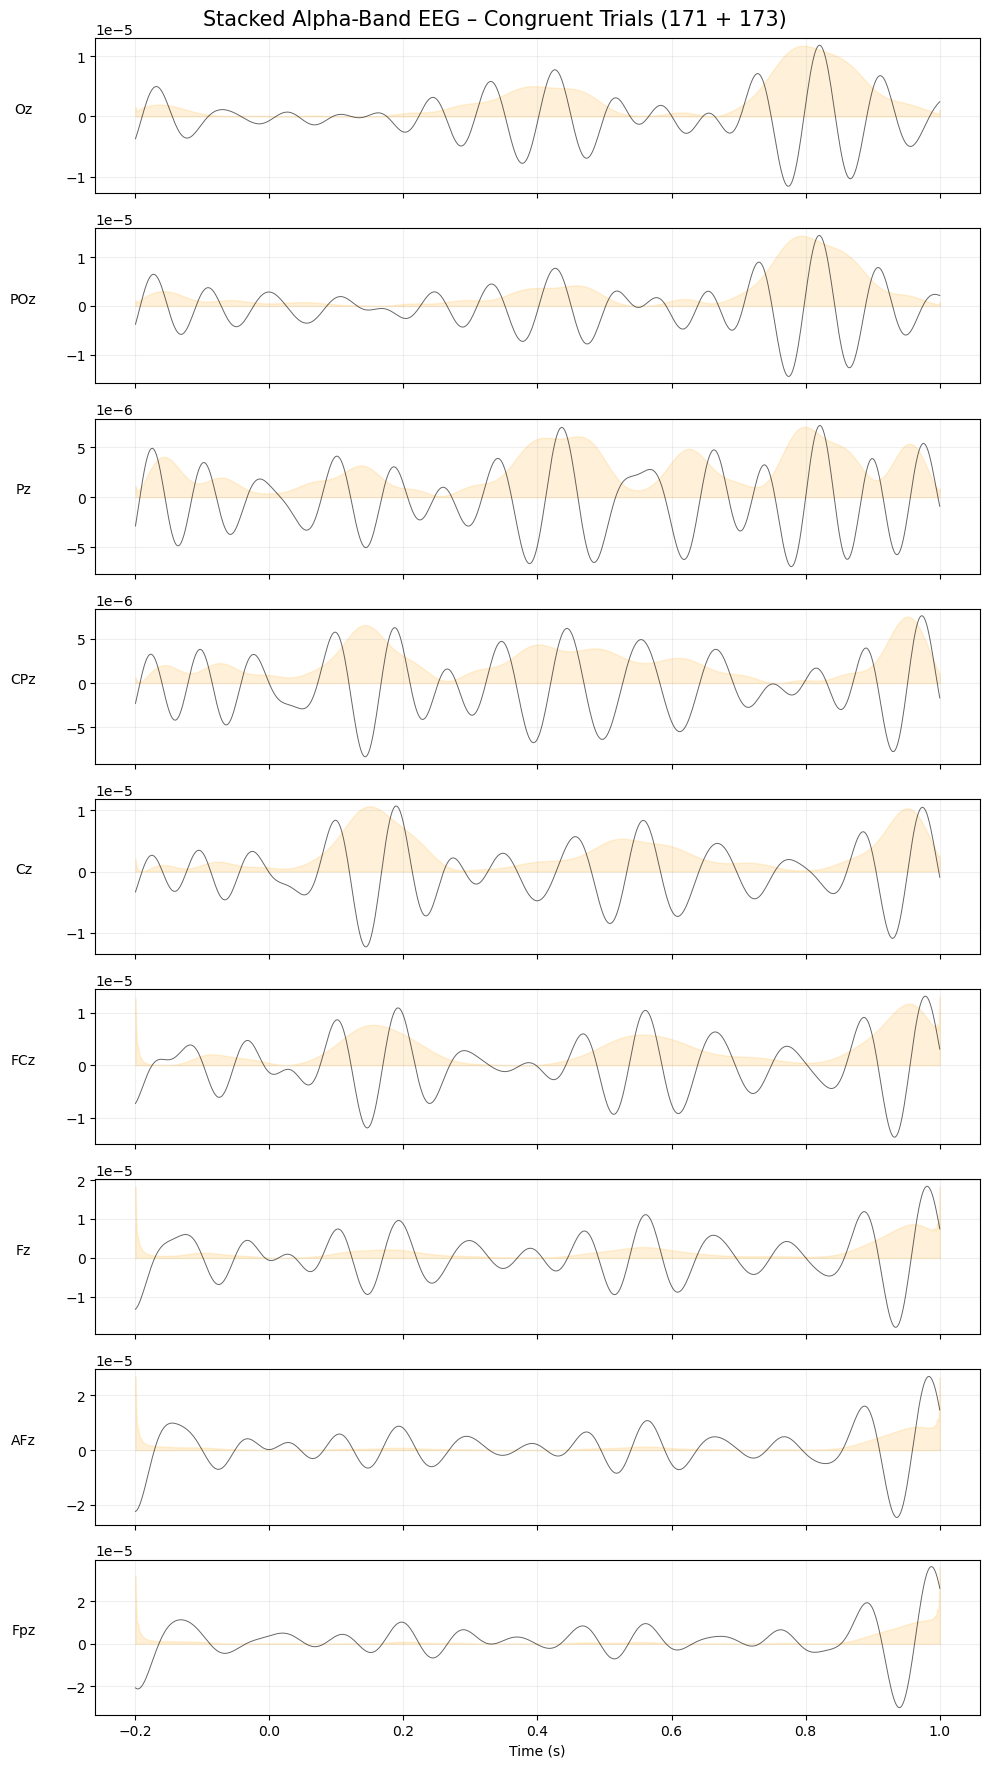

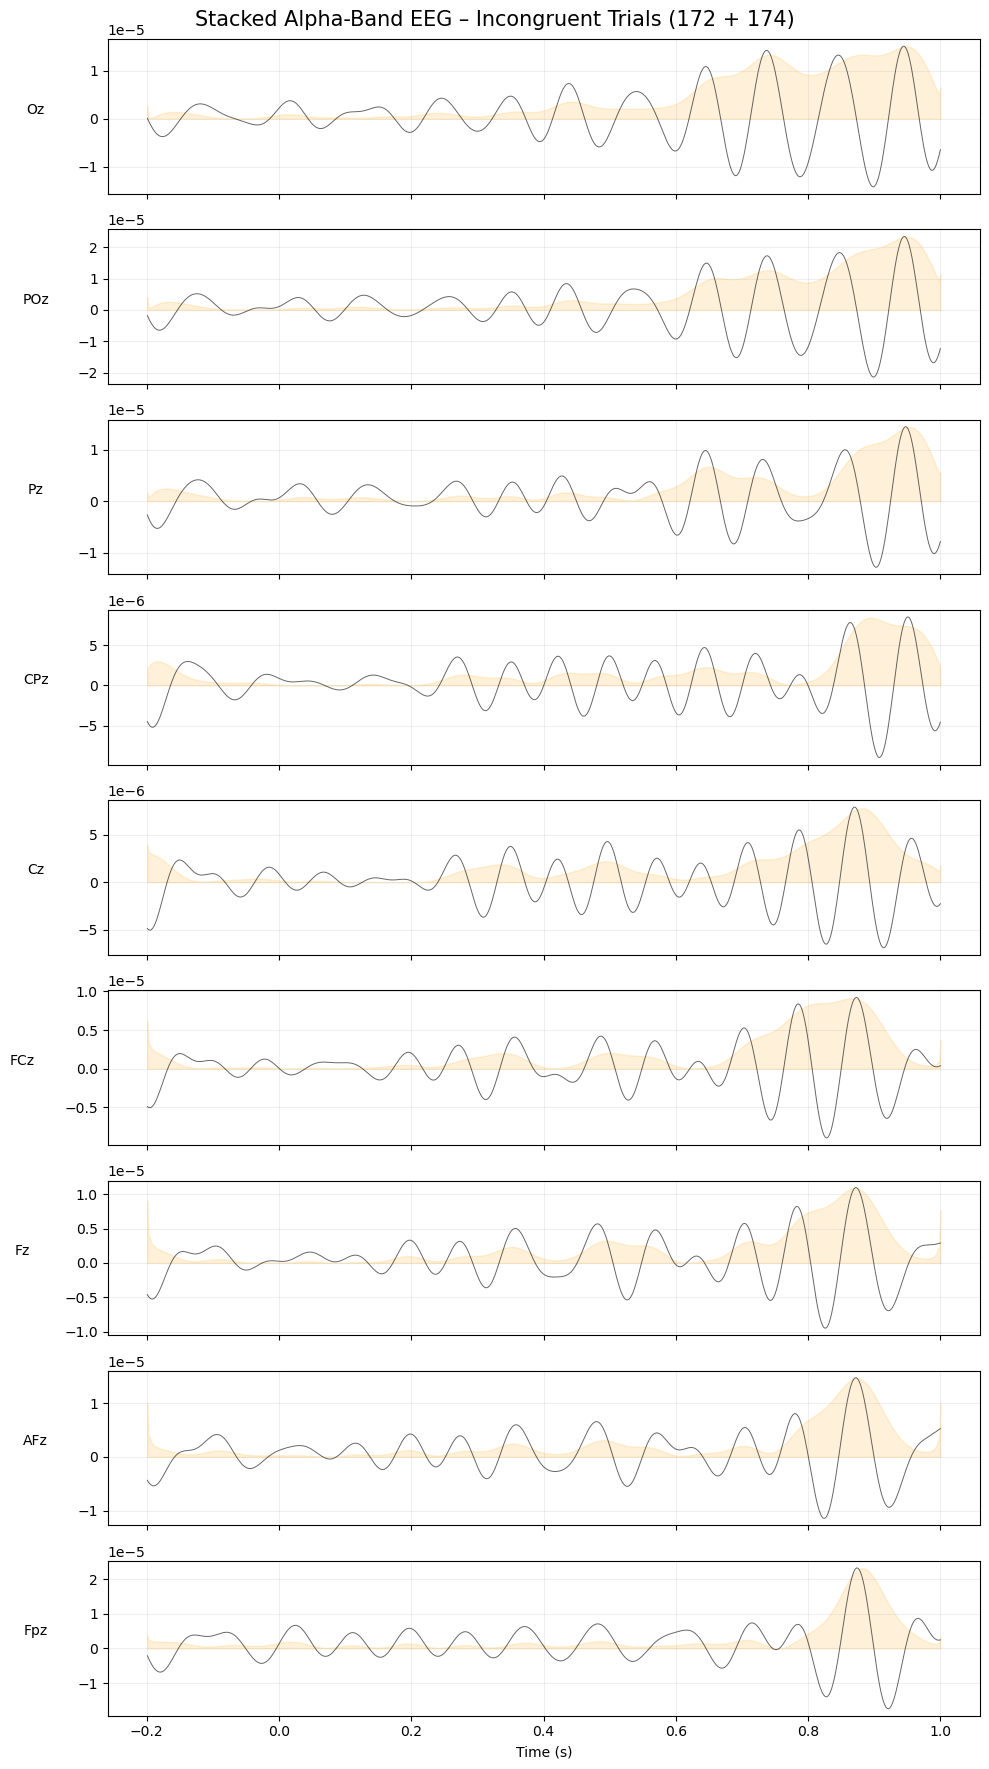

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# ----------- SETTINGS -----------
channels = ['Oz', 'POz', 'Pz', 'CPz', 'Cz', 'FCz', 'Fz', 'AFz', 'Fpz']
ch_idxs = [epochs.ch_names.index(ch) for ch in channels]

event_id = {
    'M-cong': 171,
    'M-incong': 172,
    'F-cong': 173,
    'F-incong': 174
}

# groupings
congruent_ids = ['M-cong', 'F-cong']
incongruent_ids = ['M-incong', 'F-incong']

# extract epochs
epochs_cong = epochs[congruent_ids]
epochs_incong = epochs[incongruent_ids]

# helper to plot stacked epochs + power shadow
def plot_group(epo, title):
    data = epo.get_data()        # (n_epochs, n_channels, n_times)
    times = epo.times

    fig, axes = plt.subplots(len(channels), 1, figsize=(10, 18), sharex=True)

    for ax, ch, ch_idx in zip(axes, channels, ch_idxs):

        for ep in range(1):
            sig = data[ep, ch_idx, :]

            # Hilbert envelope
            analytic = hilbert(sig)
            amp = np.abs(analytic)
            power = amp ** 2
            power_norm = power / (power.max() + 1e-12)

            # shadow
            ax.fill_between(
                times,
                0,
                power_norm * sig.max(),
                color='orange',
                alpha=0.15
            )

            # trace
            ax.plot(times, sig, color='black', alpha=0.6, linewidth=0.7)

        ax.set_ylabel(ch, rotation=0, labelpad=30, fontsize=10)
        ax.grid(True, alpha=0.2)

    axes[-1].set_xlabel("Time (s)")
    fig.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()


# ---------- PLOT BOTH CONDITIONS ----------------

plot_group(epochs_cong, "Stacked Alpha-Band EEG – Congruent Trials (171 + 173)")
plot_group(epochs_incong, "Stacked Alpha-Band EEG – Incongruent Trials (172 + 174)")


In [ ]:
epochs['M-cong'].plot(picks=['Fz','AFz','Fpz'])

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [178]:
congruent = mne.combine_evoked(
    [epochs['M-cong'].average(), epochs['F-cong'].average()],
    weights='equal'
)

incongruent = mne.combine_evoked(
    [epochs['M-incong'].average(), epochs['F-incong'].average()],
    weights='equal'
)

In [179]:
channels_of_interest = ['Oz', 'POz', 'Pz', 'CPz', 'Cz', 'FCz', 'Fz', 'AFz', 'Fpz']


In [180]:
evokeds_dict = {
    'congruent': congruent,
    'incongruent': incongruent
}

C:\Users\NARONG\AppData\Local\Temp\ipykernel_11076\1982883836.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


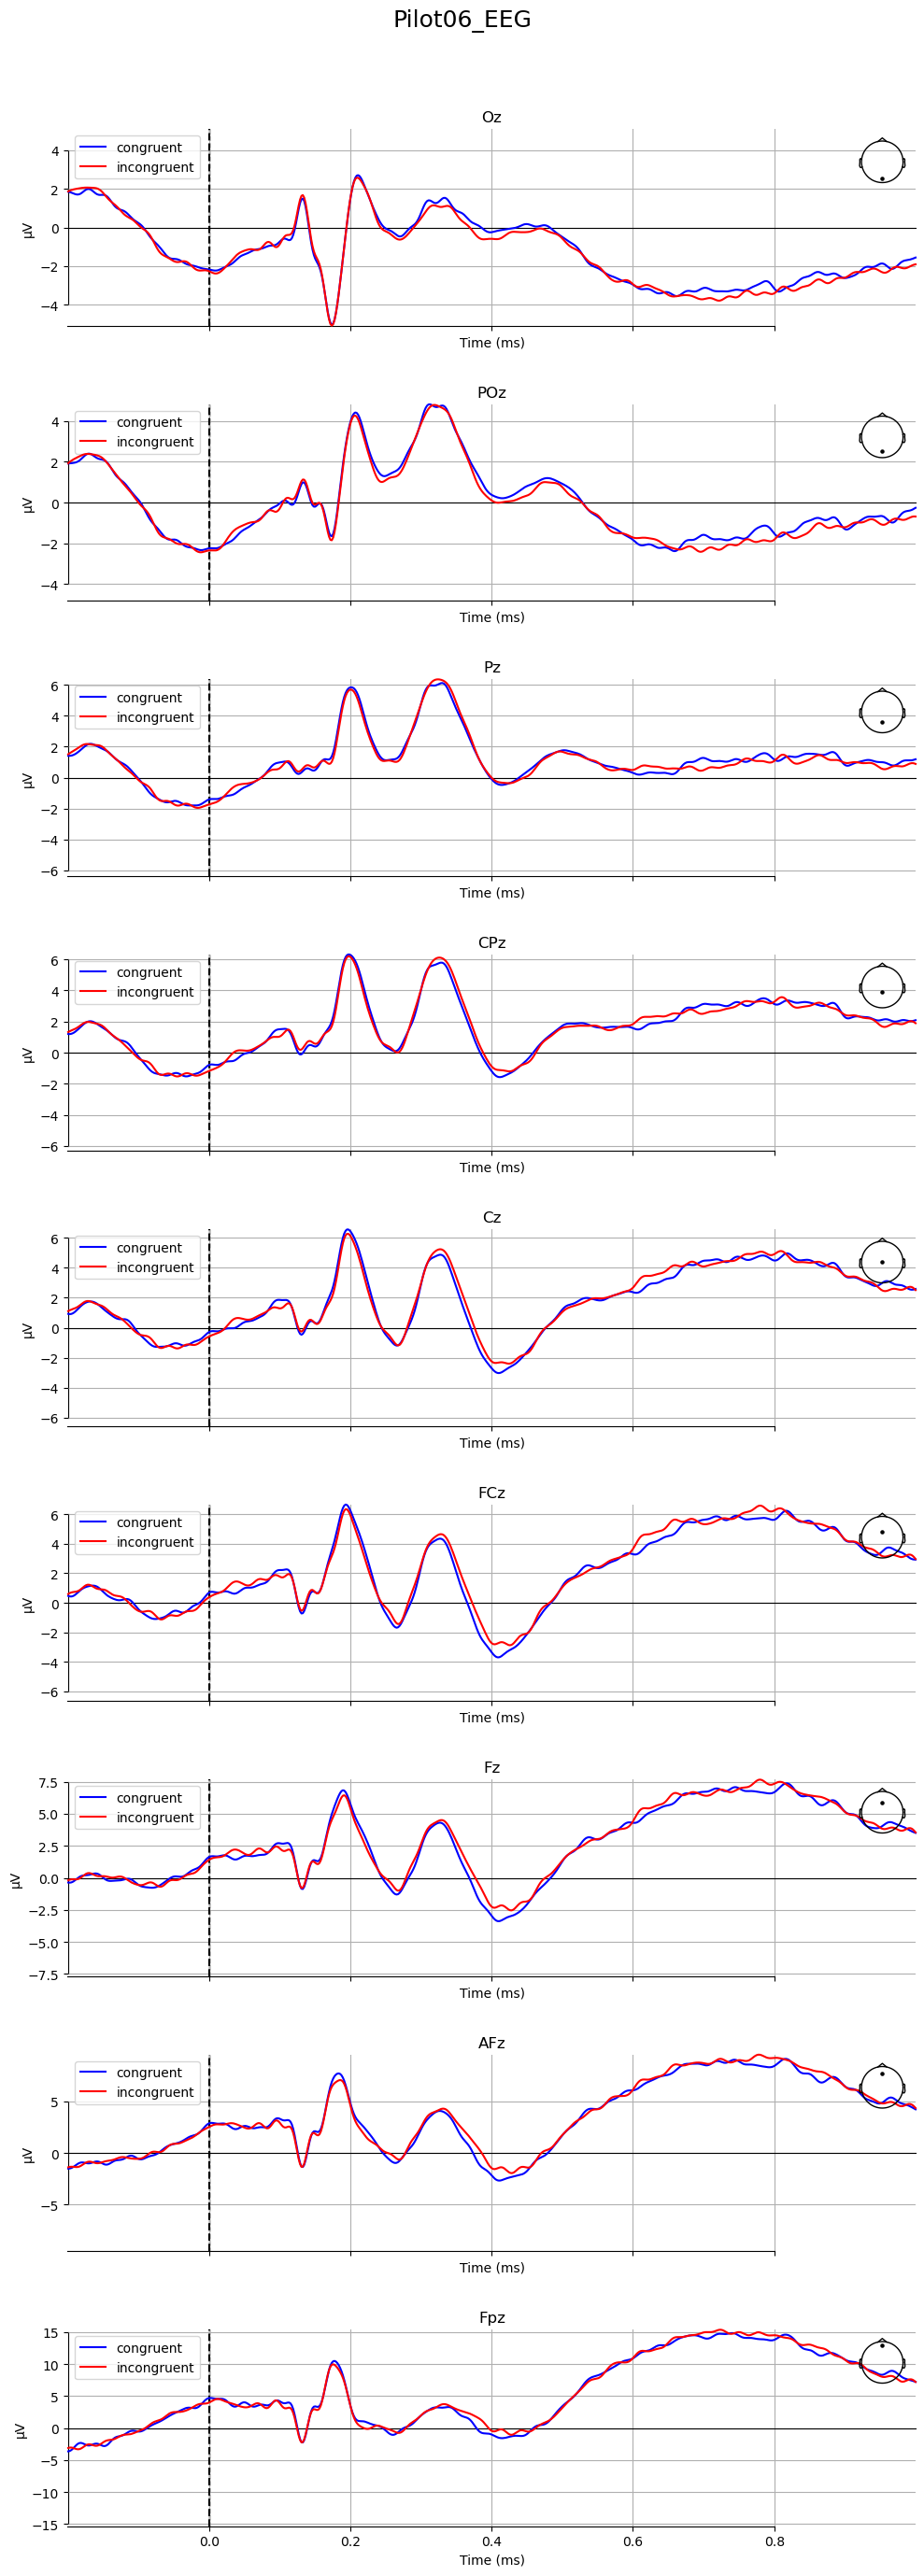

In [182]:
import matplotlib.pyplot as plt

n_channels = len(channels_of_interest)
fig, axes = plt.subplots(n_channels, 1, figsize=(10, 3*n_channels), sharex=True)

for i, ch in enumerate(channels_of_interest):
    mne.viz.plot_compare_evokeds(
        evokeds_dict,
        picks=[ch],
        axes=axes[i],
        colors={'congruent': 'blue', 'incongruent': 'red'},
        show=False
    )
    axes[i].set_title(ch)
    axes[i].set_xlim(incongruent.times[0], congruent.times[-1])
    axes[i].grid(True)

for ax in axes:
    ax.axvline(0, color='k', linestyle='--')
    ax.set_xlabel('Time (ms)')

fig.suptitle('Pilot06_EEG', fontsize=18, y=1.02)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()
